In [1]:
import matplotlib.pyplot as plt                           # Plotting
import numpy as np                                        # Numpy: Tableau Multidimensionnel
import pandas as pd                                       # Panda: Manipulation des Dataframe
import seaborn as sns                                     # Librairie de visualisation

# Librairies Scikit Learn
from sklearn.model_selection import train_test_split      # Split des jeux de données
from sklearn.metrics import confusion_matrix              # Analyse des performances de classification
from mlxtend.plotting import plot_confusion_matrix

# Dataset des chiffres du MNIST
#from keras.datasets import mnist

# Librairies Keras pour la construction du réseau CNN
from keras.models import Model, Sequential
from keras.models import load_model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import UpSampling2D, Dropout, Dense, Flatten

from tensorflow.keras.utils import plot_model              # Visualisation du modèle crée
from tensorflow.keras.callbacks import EarlyStopping       # Permet d'arrêter l'apprentissage quand il n'y a plus de progression
from keras.optimizers import Adam                          # Optimizer Adam

2024-07-25 09:28:31.421560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 09:28:32.397481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-25 09:28:32.397519: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-07-25 09:28:32.529316: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 09:28:35.012452: W tensorflow/stream_executor/platform/de

# Préparation

In [2]:
# Fonction pour afficher les données matricielles sous forme d'images
def display_image(X, y, n, label=False):
    plt.figure(figsize=(20,2))
    for i in range(10):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(X.values[i].reshape(28,28))
        if label:
            plt.title("Digit: {}".format(y[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [3]:
# Path vers les jeux de données
train_dir = "train.csv"
test_dir = "test.csv"

In [4]:
# Lecture du jeu d'entrainement via pandas à partir d'un fichier csv
df_train = pd.read_csv(train_dir)

# Récupération des informations sur le Dataframe du jeu de données
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [5]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
y_train = df_train['label']
X_train = df_train.drop(columns=['label'])

In [7]:
# Les labels prennent les valeurs des classes de chiffres
y_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

/home/louve/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


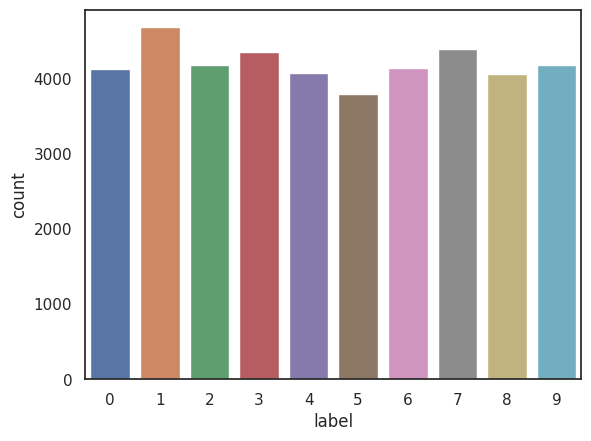

In [8]:
# Visualisation de la répartition des labels
sns.set(style='white', context='notebook', palette='deep')
ax = sns.countplot(y_train)

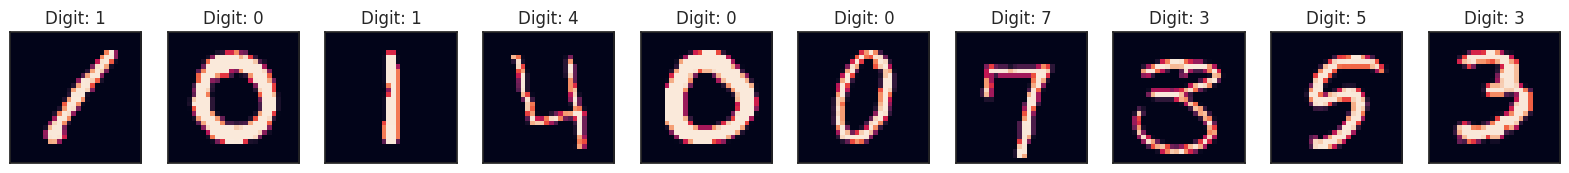

In [9]:
# On affiche 1O images connues avec leur labels
# X_train.values[0].reshape(28,28)
display_image(X_train, y_train, n=10, label=True)

In [10]:
# 1. Split entre jeu d'entrainement et jeu de validation avec un ratio de 90/10
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [11]:
# 2. Reshape des data pour les formatter en 28x28x1 c'est à dire une matrice 3D
X_train = X_train.values.reshape(-1, 28,28,1)
X_val = X_val.values.reshape(-1, 28,28,1)

In [12]:
# Affichage de la nouvelle shape des données (maintenant sous forme de matrice 28x28)
X_train.shape

(37800, 28, 28, 1)

In [13]:
# Application d'un seuil pour contraster les images
def apply_contrast(X, seuil=150):
    X_contrast = X.copy()
    X_contrast[X_contrast >= seuil] = 255
    X_contrast[X_contrast < seuil] = 0
    return X_contrast

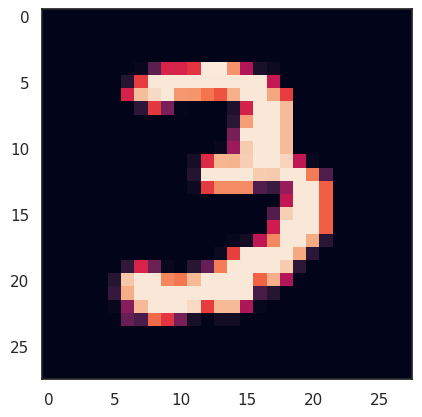

In [14]:
plt.imshow((X_train[9].squeeze()))

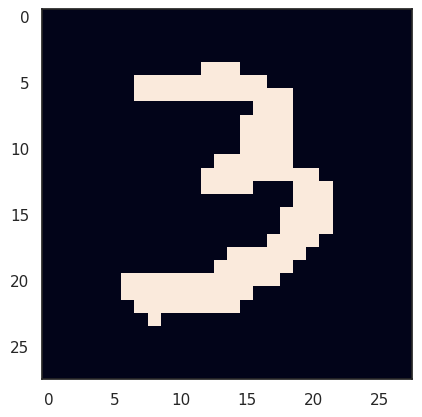

In [15]:
image = apply_contrast(X_train[9])
plt.imshow(image.squeeze())

In [16]:
# 3. Normalisation des données pour avoir des valeurs de pixels entre 0 et 255
# Nous n'avons pas besoin d'un Scaler car ici la normalisation est simple, donc nous la faisons à la main
X_train = X_train / 255.0
X_val = X_val / 255.0

In [17]:
# 4. Remplacement des valeurs des labels par des valeurs catégoriques
# Exemple => "2" sera codée [0 0 1 0 0 0 0 0 0 0] 
Y_train  = pd.get_dummies(y_train).values
Y_val  = pd.get_dummies(y_val).values

In [18]:
print("La valeur {} est encodée vers le vecteur {}".format(y_train[0], Y_train[0]))
print("valeur {} transformée en vecteur: {}".format(y_train[20], Y_train[20]))

La valeur 1 est encodée vers le vecteur [0 1 0 0 0 0 0 0 0 0]
valeur 8 transformée en vecteur: [0 0 0 0 0 0 0 0 1 0]


In [19]:
# Augmentation des images avec un processing :
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=20,                   # randomly rotate images in the range 
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally 
          height_shift_range=0.1,              # randomly shift images vertically 
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

# CNN

## Couche de Convolution et MaxPooling

In [20]:
# Initialisation 
model = Sequential()
#     filters : nombres de filtres de convolutions
#     kernel_size : taille des filtres de la fenêtre de convolution 
#     input_shape : taille de l'image en entrée (à préciser seulement pour la première couche)
#     activation  : choix de la fonction d'activation

# BatchNormalisation : permet de normaliser les coefficients d'activation afin de les maintenirs proche de 0
# pour simplifier les calculs numériques

# MaxPooling : Opération de maxPooling sur des données spatiales (2D)

# Dropout : permet de désactiver aléatoirement une proportion de neurones
# (afin d'éviter l'overfitting sur le jeu d'entrainement)

model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation='relu', padding='Same', input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation='relu', padding='Same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(strides=(2,2)))
model.add(Dropout(0.2))

2024-07-25 09:28:43.174708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-25 09:28:43.174863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-25 09:28:43.174946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-07-25 09:28:43.175016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-07-25 09:28:43.175083: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

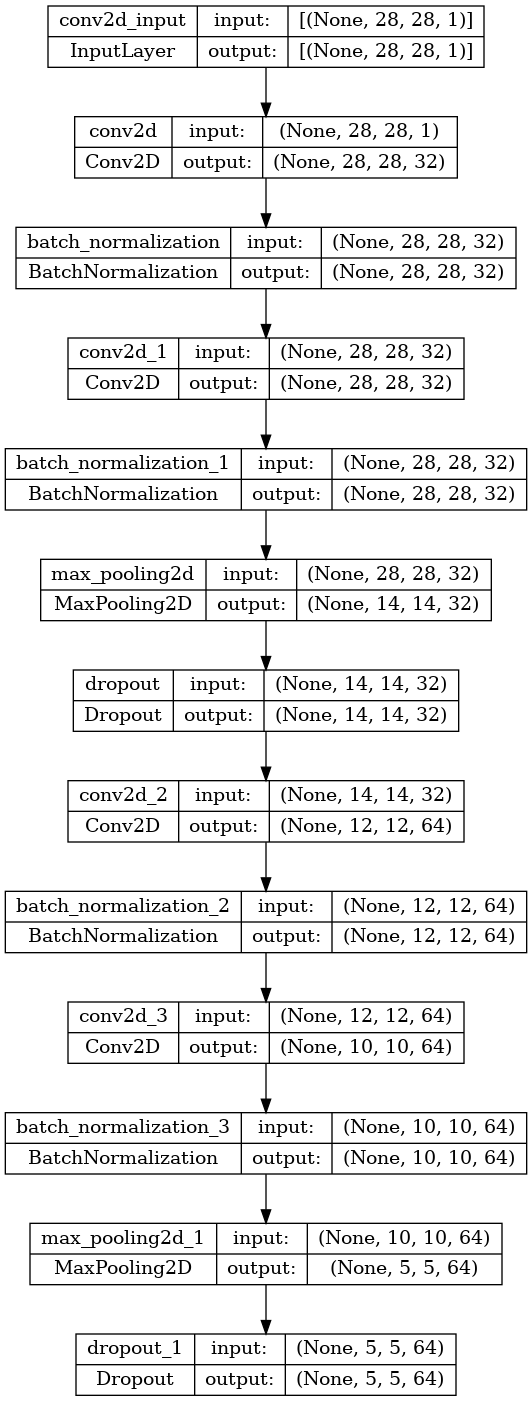

In [21]:
# Visualisation du schémas de l'architecture de neurones
plot_model(model, show_shapes=True, show_layer_names=True)

## Classifier (couche entièrement Connectée)

In [22]:
# Flatten : conversion d'une matrice en un vecteur plat
# Dense   : neurones

model.add(Flatten())     # Applatissement de la sortie du réseau de convolution

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))

# Couche de sortie : nombre de neurones = nombre de classe à prédire
model.add(Dense(units=10, activation='softmax'))

In [23]:
# Récapitulatif de l'architecture modèle
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                        

In [24]:
# Sélection de l'optimiser pour la decente de gradient
model.compile(loss='categorical_crossentropy', 
              optimizer = Adam(lr=0.0001), 
              metrics=["accuracy"])

/home/louve/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
# Permet de s'arrêter si le metric ne s'améliore pas
# https://keras.io/api/callbacks/early_stopping/
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=30, 
                          verbose=1,
                          restore_best_weights=True,
                          mode='auto')

In [26]:
# Démarrage de l'entrainement du réseau
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                           steps_per_epoch=200,              # nombre image entrainement / batch_size
                           epochs=150,                       # nombre de boucle à réaliser sur le jeu de données complet
                           verbose=1,                        # verbosité
                           callbacks = [earlystop],          # callback pour arrêt si non progression
                           validation_data=(X_val, Y_val))   # données de validation (X(données) et y(labels))

/tmp/ipykernel_1216/287408282.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),


Epoch 1/150
200/200 [==============================] - 17s 79ms/step - loss: 1.7849 - accuracy: 0.4112 - val_loss: 4.5725 - val_accuracy: 0.1090
Epoch 2/150
200/200 [==============================] - 15s 75ms/step - loss: 0.8907 - accuracy: 0.7052 - val_loss: 3.7692 - val_accuracy: 0.1271
Epoch 3/150
200/200 [==============================] - 15s 75ms/step - loss: 0.5632 - accuracy: 0.8156 - val_loss: 0.2363 - val_accuracy: 0.9355
Epoch 4/150
200/200 [==============================] - 15s 73ms/step - loss: 0.4187 - accuracy: 0.8645 - val_loss: 0.0945 - val_accuracy: 0.9695
Epoch 5/150
200/200 [==============================] - 15s 74ms/step - loss: 0.3363 - accuracy: 0.8952 - val_loss: 0.0928 - val_accuracy: 0.9662
Epoch 6/150
200/200 [==============================] - 15s 74ms/step - loss: 0.3143 - accuracy: 0.9013 - val_loss: 0.0934 - val_accuracy: 0.9690
Epoch 7/150
200/200 [==============================] - 15s 76ms/step - loss: 0.2559 - accuracy: 0.9202 - val_loss: 0.0806 - val_ac

200/200 [==============================] - 14s 70ms/step - loss: 0.0542 - accuracy: 0.9856 - val_loss: 0.0266 - val_accuracy: 0.9921
Epoch 58/150
200/200 [==============================] - 14s 71ms/step - loss: 0.0490 - accuracy: 0.9852 - val_loss: 0.0261 - val_accuracy: 0.9912
Epoch 59/150
200/200 [==============================] - 14s 71ms/step - loss: 0.0563 - accuracy: 0.9834 - val_loss: 0.0234 - val_accuracy: 0.9936
Epoch 60/150
200/200 [==============================] - 16s 82ms/step - loss: 0.0584 - accuracy: 0.9817 - val_loss: 0.0278 - val_accuracy: 0.9912
Epoch 61/150
200/200 [==============================] - 15s 75ms/step - loss: 0.0577 - accuracy: 0.9835 - val_loss: 0.0313 - val_accuracy: 0.9912
Epoch 62/150
200/200 [==============================] - 15s 75ms/step - loss: 0.0515 - accuracy: 0.9855 - val_loss: 0.0306 - val_accuracy: 0.9902
Epoch 63/150
200/200 [==============================] - 16s 78ms/step - loss: 0.0558 - accuracy: 0.9820 - val_loss: 0.0266 - val_accuracy

200/200 [==============================] - 15s 74ms/step - loss: 0.0377 - accuracy: 0.9897 - val_loss: 0.0208 - val_accuracy: 0.9943
Epoch 114/150
200/200 [==============================] - 15s 74ms/step - loss: 0.0437 - accuracy: 0.9870 - val_loss: 0.0236 - val_accuracy: 0.9910
Epoch 115/150
200/200 [==============================] - 15s 72ms/step - loss: 0.0374 - accuracy: 0.9895 - val_loss: 0.0197 - val_accuracy: 0.9943
Epoch 116/150
200/200 [==============================] - 15s 74ms/step - loss: 0.0384 - accuracy: 0.9870 - val_loss: 0.0188 - val_accuracy: 0.9940
Epoch 117/150
200/200 [==============================] - 15s 73ms/step - loss: 0.0325 - accuracy: 0.9894 - val_loss: 0.0156 - val_accuracy: 0.9960
Epoch 118/150
200/200 [==============================] - 14s 70ms/step - loss: 0.0415 - accuracy: 0.9887 - val_loss: 0.0199 - val_accuracy: 0.9940
Epoch 119/150
200/200 [==============================] - 15s 76ms/step - loss: 0.0386 - accuracy: 0.9887 - val_loss: 0.0194 - val_ac

In [27]:
# Evaluation de la performance du modèle
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0155, final accuracy: 0.9938


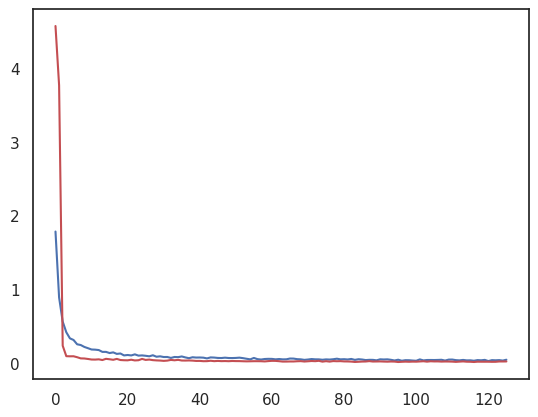

In [28]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

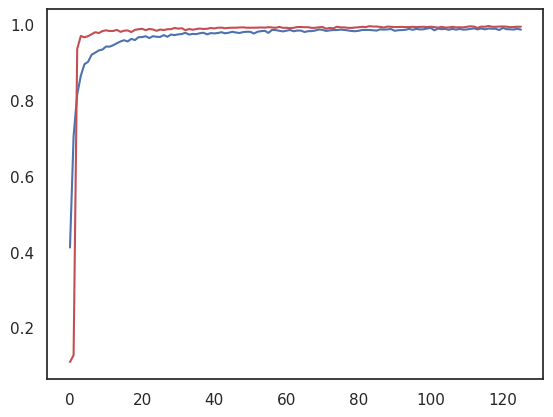

In [29]:
plt.plot(hist.history['accuracy'], color='b')
plt.plot(hist.history['val_accuracy'], color='r')
plt.show()

In [30]:
# Prédictions et vecteur de probabilité
Y_hat = model.predict(X_val)
Y_hat[0]

132/132 [==============================] - 2s 17ms/step


array([9.9999982e-01, 7.8640490e-11, 1.0640718e-08, 8.5188705e-12,
       1.4083861e-09, 2.8189204e-11, 4.0243431e-09, 1.5444805e-09,
       7.0321859e-09, 7.7921989e-08], dtype=float32)

In [31]:
# Génération des vecteurs de verité (Y_true) et de prédiction (Y_pred)
Y_pred = np.argmax(Y_hat, axis=1)
Y_true = np.argmax(Y_val, axis=1)

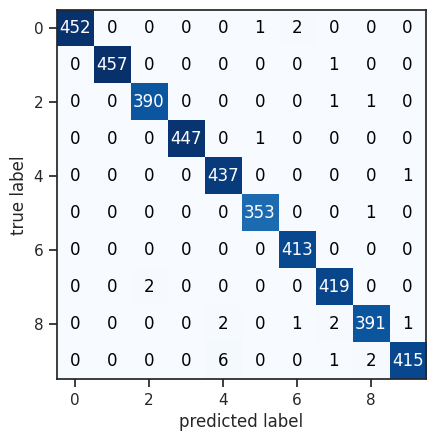

In [32]:
# Génération d'une matrice de confusion pour observer les erreurs
# Toutes les valeurs sortant de la diagonales sont les erreurs de classification

cm = confusion_matrix(Y_true, Y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [33]:
# On identifie les indices qui ont été mal classifié

diff_indices = np.where(Y_true != Y_pred)[0]
diff_indices

array([  67,   87,  439,  624, 1365, 1735, 1945, 2160, 2438, 2446, 2457,
       2486, 2554, 2568, 2875, 3068, 3081, 3176, 3421, 3429, 3456, 3494,
       3558, 3840, 3883, 4123])

In [34]:
# On met les mauvaises classifications dans une array que l'on met aux bonnes dimensions pour affichage

X_err = X_val[diff_indices]
X_err = X_err*255
X_err = X_err.reshape(X_err.shape[0],28, 28)

Image: 0 - Indice: 67: Vérité 3, Prédiction: 5 avec proba: 0.7930715084075928
Image: 1 - Indice: 87: Vérité 9, Prédiction: 8 avec proba: 0.6545583009719849
Image: 2 - Indice: 439: Vérité 0, Prédiction: 6 avec proba: 0.4867253005504608
Image: 3 - Indice: 624: Vérité 7, Prédiction: 2 avec proba: 0.7029591202735901
Image: 4 - Indice: 1365: Vérité 9, Prédiction: 4 avec proba: 0.6408137679100037
Image: 5 - Indice: 1735: Vérité 8, Prédiction: 9 avec proba: 0.7649325132369995
Image: 6 - Indice: 1945: Vérité 9, Prédiction: 4 avec proba: 0.7464691996574402
Image: 7 - Indice: 2160: Vérité 2, Prédiction: 7 avec proba: 0.6478224992752075
Image: 8 - Indice: 2438: Vérité 8, Prédiction: 7 avec proba: 0.4630459249019623
Image: 9 - Indice: 2446: Vérité 7, Prédiction: 2 avec proba: 0.7047669291496277



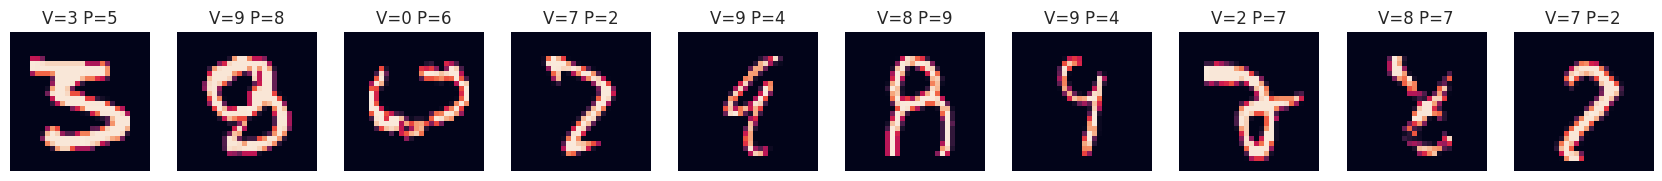

In [35]:
# Affichage de 10 images incorrectes
plt.figure(figsize=(60, 20))
for i in range (0, 10):
    print("Image: {} - Indice: {}: Vérité {}, Prédiction: {} avec proba: {}".format(i, diff_indices[i], Y_true[diff_indices[i]], Y_pred[diff_indices[i]], Y_hat[diff_indices[i]][Y_pred[diff_indices[i]]] ))
    plt.subplot(1, 28, i + 1)
    plt.imshow(X_err[i])
    plt.title(f'V={Y_true[diff_indices[i]]} P={Y_pred[diff_indices[i]]}')
    plt.axis('off')

print("")
plt.show()

# Test

In [36]:
# Lecture jeu de test
X_test = pd.read_csv(test_dir)

# Traitement des données de la même façon que pour l'entrainement
# Reshape
X_test = X_test.values.reshape(-1, 28,28,1)

# Normalisation
X_test = X_test / 255.0

In [37]:
# Prédictions sur le jeu de test
Y_hat = model.predict(X_test, verbose=1)
Y_pred = np.argmax(Y_hat, axis=1)

875/875 [==============================] - 15s 17ms/step


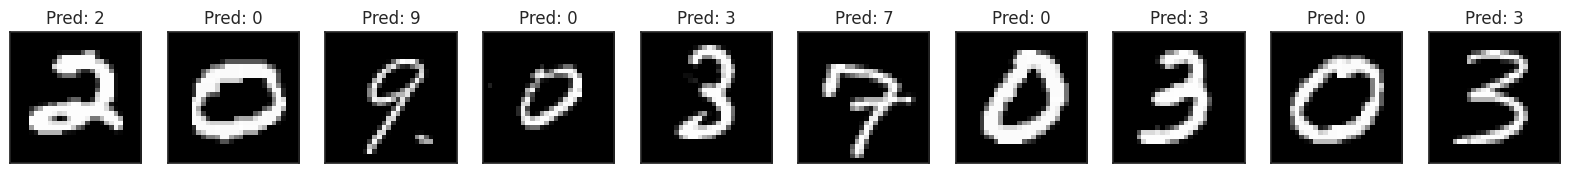

In [38]:
# Affichage des prédictions pour quelques images de test
def display_predictions(X_test, Y_pred, n=10):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(X_test[i].squeeze(), cmap='gray')
        plt.title("Pred: {}".format(Y_pred[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Afficher les 10 premières prédictions
display_predictions(X_test, Y_pred, n=10)

In [39]:
model.save('cnn_model.h5')